# Importing libraries

In [2]:
!pip install scikit-learn


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\shlomias\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [19]:
import numpy as np
import time
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, log_loss
import matplotlib.pyplot as plt
import seaborn as sns

# Loading the data

In [20]:
X = np.load('data/cifar10_features.npy')
Y = np.load('data/cifar10_labels.npy')

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

print("Feature Shape:", X.shape)
print("Label Shape:", Y.shape)
print("Example Features:", X[:5])
print("Example Labels:", Y[:5])

Feature Shape: (50000, 16)
Label Shape: (50000,)
Example Features: [[-10.316492    -9.219499     5.6836095   10.560703    -7.8908167
   -5.444539   -13.386533     8.584426     1.2373098    2.620596
   11.018443    -4.2349334    5.0958567    6.3705587   -1.8090839
    7.2225003 ]
 [  7.481172     6.139558     3.3403616    0.08668663  -0.77877134
   -8.864485    -6.7062845   -1.0690573    4.9872813    1.6038104
    6.423094    -0.7426312    2.5941138  -10.134348     4.1819096
    0.21896511]
 [ 11.439068     6.9961743    0.52943176   4.803377    -2.0376425
  -13.85577     -5.317335     2.1301713   11.248181     6.665526
   15.688234    -4.421451     3.9242096  -13.232056     1.9560468
    1.4480063 ]
 [ -0.20259686  -1.2906628    2.8221395    7.9919014   -5.1371694
    8.211122     4.824665    -2.3066144   -5.748542    -1.8008168
  -14.819701   -11.07256      1.9884455   -3.4726849   10.8494835
   -9.39806   ]
 [ -4.3365293   -6.5237374    6.6791663   -3.4806645    5.330081
   -7.8313446

## function for test

In [21]:
def testmymodel(model, X_test, y_test):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    return acc


# One-vs-All model training

In [22]:
class MyOVAClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self):
        self.models = []

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        self.models = []
        for c in self.classes_:
            y_binary = (y == c).astype(int)
            model = LogisticRegression(solver='lbfgs', max_iter=1000)
            model.fit(X, y_binary)
            self.models.append(model)
        return self

    def predict(self, X):
        probas = np.array([model.predict_proba(X)[:, 1] for model in self.models])
        return np.argmax(probas, axis=0)

    def predict_proba(self, X):
        probas = np.array([model.predict_proba(X)[:, 1] for model in self.models]).T
        return probas

    def get_params(self, deep=True):
        return {}

    def set_params(self, **params):
        return self


In [23]:
model_ova_custom = MyOVAClassifier()

start_time = time.time()
model_ova_custom.fit(X_train, y_train)
ova_time = time.time() - start_time

y_pred = model_ova_custom.predict(X_test)
y_proba = model_ova_custom.predict_proba(X_test)

ova_acc = testmymodel(model_ova_custom, X_test, y_test)
ova_f1 = f1_score(y_test, y_pred, average='macro')
ova_loss = log_loss(y_test, y_proba)

print(f"OVA Accuracy: {ova_acc:.4f}")
print(f"OVA F1-mean: {ova_f1:.4f}")
print(f"OVA Log Loss: {ova_loss:.4f}")
print(f"OVA Training Time: {ova_time:.2f} seconds")


OVA Accuracy: 0.9610
OVA F1-mean: 0.9612
OVA Log Loss: 0.1581
OVA Training Time: 1.04 seconds


C:\Users\shlomias\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


# Softmax model training

In [24]:
# Logistic Regression - Softmax
model_softmax = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)

start_time = time.time()
model_softmax.fit(X_train, y_train)
softmax_time = time.time() - start_time

softmax_acc = testmymodel(model_softmax, X_test, y_test)
softmax_f1 = f1_score(y_test, model_softmax.predict(X_test), average='macro')
softmax_loss = log_loss(y_test, model_softmax.predict_proba(X_test))

print(f"Softmax Accuracy: {softmax_acc:.4f}")
print(f"Softmax F1-mean: {softmax_f1:.4f}")
print(f"Softmax Log Loss: {softmax_loss:.4f}")
print(f"Softmax Training Time: {softmax_time:.2f} seconds")


C:\Users\shlomias\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Softmax Accuracy: 0.9629
Softmax F1-mean: 0.9632
Softmax Log Loss: 0.1077
Softmax Training Time: 1.63 seconds


## Confusion Matrix for One-vs-All

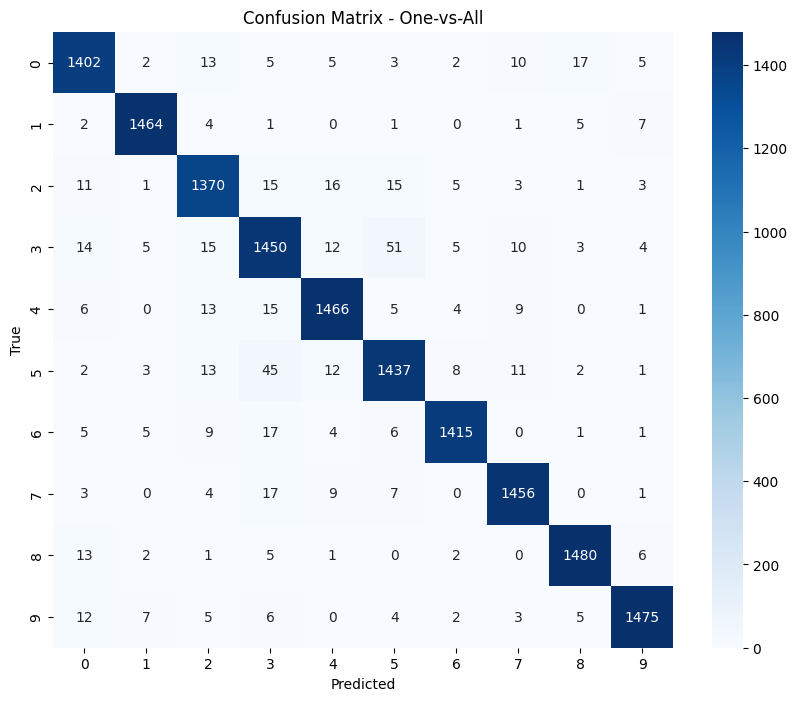

In [25]:
y_pred_ova = model_ova_custom.predict(X_test)
cm = confusion_matrix(y_test, y_pred_ova)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - One-vs-All')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Class 3 (row 3) makes a lot of mistakes with class 5 - there are 51 mistakes there - relatively high compared to the rest!

Class 5 (row 5) also makes mistakes with class 3 - there are 45 mistakes.

Classes 3 and 5 are the most "problematic" pair - the model has a hard time distinguishing between them (it's a cat (class 3) versus a dog (class 5) so it makes sense.

A new Binary Classifier model was built that only distinguishes between them.

In [26]:
# Filter classes 3 and 5 only
selected_classes = [3, 5]

train_mask = np.isin(y_train, selected_classes)
test_mask = np.isin(y_test, selected_classes)

X_train_2 = X_train[train_mask]
y_train_2 = y_train[train_mask]
X_test_2 = X_test[test_mask]
y_test_2 = y_test[test_mask]

# Building the new model
model_2classes = LogisticRegression(multi_class='ovr', solver='lbfgs', max_iter=1000)
model_2classes.fit(X_train_2, y_train_2)

# test
acc_2classes = testmymodel(model_2classes, X_test_2, y_test_2)
f1_2classes = f1_score(y_test_2, model_2classes.predict(X_test_2), average='macro')
loss_2classes = log_loss(y_test_2, model_2classes.predict_proba(X_test_2))

print(f"Accuracy for Class 3 vs 5 Model: {acc_2classes:.4f}")
print(f"F1 Score for Class 3 vs 5 Model: {f1_2classes:.4f}")
print(f"Loss for Class 3 vs 5 Model: {loss_2classes:.4f}")


Accuracy for Class 3 vs 5 Model: 0.9623
F1 Score for Class 3 vs 5 Model: 0.9623
Loss for Class 3 vs 5 Model: 0.0968


C:\Users\shlomias\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


## Integrated prediction function with auxiliary model

In [27]:
def predict_with_helper(main_model, helper_model, X_test):
    main_preds = main_model.predict(X_test)
    mask = np.isin(main_preds, [3, 5])
    if np.any(mask):
        helper_preds = helper_model.predict(X_test[mask])
        main_preds[mask] = helper_preds
    return main_preds

# Combination

In [28]:
# Normal forecast (for testing)
y_pred_main = model_ova_custom.predict(X_test)

# Combined forecast with improvement for departments 3 and 5
y_pred_combined = predict_with_helper(model_ova_custom, model_2classes, X_test)

acc_before = accuracy_score(y_test, y_pred_main)
acc_after = accuracy_score(y_test, y_pred_combined)

f1_before = f1_score(y_test, y_pred_main, average='macro')
f1_after = f1_score(y_test, y_pred_combined, average='macro')

print(f"Accuracy before using helper model: {acc_before:.4f}")
print(f"Accuracy after using helper model: {acc_after:.4f}")
print(f"F1-mean before: {f1_before:.4f}")
print(f"F1-mean after: {f1_after:.4f}")

Accuracy before using helper model: 0.9610
Accuracy after using helper model: 0.9609
F1-mean before: 0.9612
F1-mean after: 0.9611


Despite running a dedicated auxiliary model for distinguishing between classes 3 and 5, no significant improvement in performance was observed.

The possible reasons for this are:
- The main model already correctly predicted most of the examples in these classes.
- The features provided do not provide additional good discrimination between these classes.
- The number of examples affected by the correction was small relative to the total data, so the overall impact on the metrics was almost negligible.

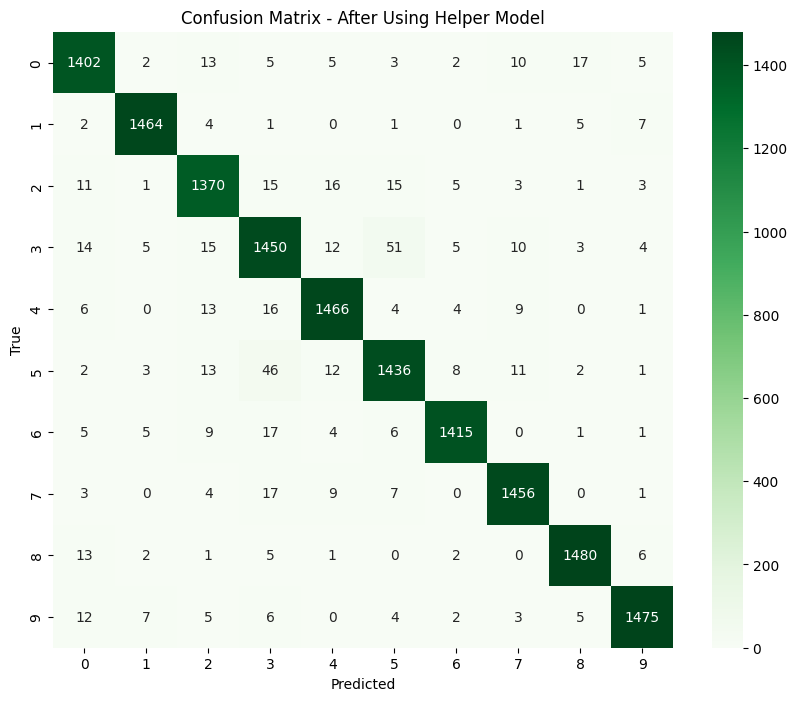

In [29]:
cm_after = confusion_matrix(y_test, y_pred_combined)

plt.figure(figsize=(10,8))
sns.heatmap(cm_after, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix - After Using Helper Model')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

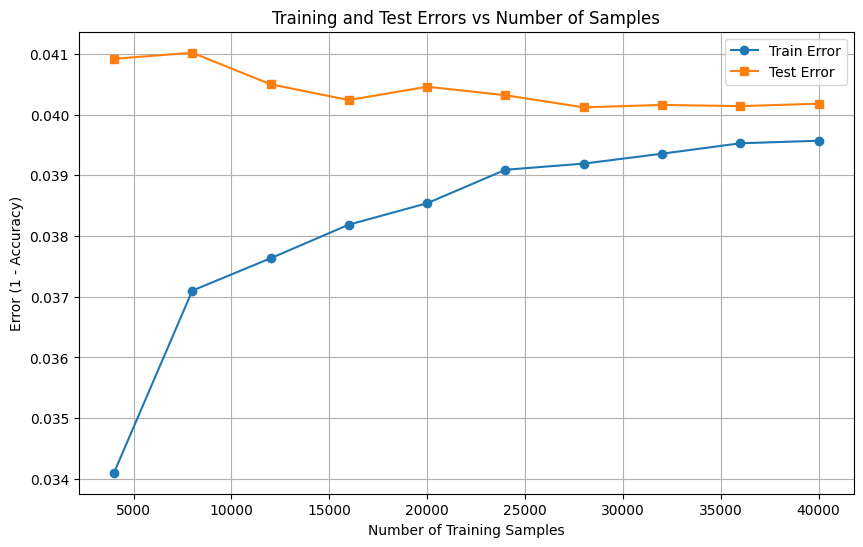

In [30]:

train_sizes, train_scores, test_scores = learning_curve(
    model_ova_custom, X, Y,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='accuracy',
    shuffle=True,
    random_state=42
)

train_errors = 1 - np.mean(train_scores, axis=1)
test_errors = 1 - np.mean(test_scores, axis=1)

plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_errors, label='Train Error', marker='o')
plt.plot(train_sizes, test_errors, label='Test Error', marker='s')
plt.xlabel('Number of Training Samples')
plt.ylabel('Error (1 - Accuracy)')
plt.title('Training and Test Errors vs Number of Samples')
plt.legend()
plt.grid(True)
plt.show()


- No Overfitting (Test error not much higher than Train error).
- No Underfitting (error in both Train and Test is relatively low).
- Your model learned well from the data — and also improves well as the dataset grows.

## Performance Comparison Between One-vs-All and Softmax

In One-vs-All it came out:
- One-vs-All Accuracy: 0.9610
- One-vs-All F1-mean: 0.9612
- One-vs-All Log Loss: 0.1581
- One-vs-All Training Time: 1.04 seconds

In Softmax it came out:
- Softmax Accuracy: 0.9629
- Softmax F1-mean: 0.9632
- Softmax Log Loss: 0.1077
- Softmax Training Time: 2.44 seconds

### Analysis:
- Softmax achieved higher accuracy than One-vs-All, both in the F1 and Log Loss metrics.
- Softmax training time was longer, but still reasonable (about 2.44 seconds).
- Overall Softmax performed better in terms of model quality.

## Auxiliary model for classes 3 and 5

In the confusion matrix we saw that there is a relatively high confusion between classes 3 and 5.
Therefore, we built a dedicated model that only classifies between these two classes.

### Model performance:

- Accuracy: 0.9623
- F1-mean: 0.9623
- Log Loss: 0.0968

## Integrating the auxiliary model into the main model

We tried to improve the predictions of the main One-vs-All model using the auxiliary model, so that in cases where a prediction of class 3 or 5 was obtained, we would use the special model.

### Results:
Before improvement:
- Accuracy: 0.9610
- F1 Score: 0.9612

After improvement:
- Accuracy: 0.9609
- F1 Score: 0.9611

### Conclusion:
- No significant improvement was observed following the use of the auxiliary model.
- It is possible that the main model already made good predictions for classes 3 and 5.
- The amount of initial errors was relatively small, so the correction did not lead to a measurable improvement in overall performance.